# RKC Students' Data Analysis

### Table of Contents

* [1. Project Description](#1)
* [2. Environment Setup](#2)
* [3. Data Profiling](#3)
* [4. Data Cleansing ](#4)
* [5. Exploratory Data Visualization](#5)
* [6. Statistical Summaries](#6)
* [7. Data Visualization for Presentation (Explanatory Visuals)](#7)
* [8. Hypothesis Testing](#8)
    * [8.1 Permutation Tests](#8.1)
    * [8.2 Student's T-Tests](#8.2)
    * [8.3 Comparing Proportions](#8.3)

## 1. Project Description  <a class="anchor" id="1"></a>
<br>The project uses survey data on adult students at Robert Kennedy College (Switzerland) to test
<br>whether the number of children and students' gender affect their academic perfomance.
<br>It also tests gender based hypotheses about students' interest on data-related fields.
<br>
<br>**Techniques used:**
<br>Data Cleaning, Descriptive Statistics, Randomization Tests
<br>T-Tests, Comparison of Frequency Distributions, Data Visualization

## 2. Environment Setup <a class="anchor" id="2"></a>

In [2]:
!python3 -m pip install plotly

In [3]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
from plotly import graph_objs as go
init_notebook_mode(connected=True)
%matplotlib inline

## 3. Data Profiling <a class="anchor" id="3"></a>

#### Open and View the File

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
file = pd.read_csv(r"data/dataanalytics-class-data.csv")
file.head()

,ID,Start time,Completion time,Email,Gender,Age,Closest biggest city near you,Number of kids (<18y) living with you,Birth Year,Number of modules completed so far,Average mark so far,Prediction for this module's mark,I enjoy working with data,I am excited about working with data,I am afraid of working with data,I am interested in understanding Data Analytics,I plan to work hard in this module,"Height (absolute value, in centimeters (cm) - sorry imperial system users!)",Height (relative)
0,2,12/17/20 9:09:33,12/17/20 9:10:55,anonymous,Woman,40-49,Lagos,0,1975,5,62.0,62,Agree,Agree,Completely Disagree,Agree,Agree,175.0,very tall
1,3,12/17/20 9:09:27,12/17/20 9:11:01,anonymous,Man,30-39,Dhaka,0,1011986,5,57.0,65,Agree,Agree,Completely Disagree,Agree,Agree,172.0,average
2,4,12/17/20 9:09:34,12/17/20 9:14:39,anonymous,Man,30-39,Hanoi,0,1989,5,61.0,64,Agree,Meh,Disagree,Meh,Meh,178.0,average
3,5,12/17/20 9:19:54,12/17/20 9:27:03,anonymous,Woman,50-59,Stockholm,0,1970,5,60.0,100,Agree,Agree,Completely Disagree,Agree,Completely Agree,164.0,average
4,6,12/17/20 9:28:13,12/17/20 9:35:44,anonymous,Man,40-49,Accra,3,1979,5,60.0,70,Completely Agree,Agree,Completely Disagree,Completely Agree,Meh,170.0,average


In [5]:
file.columns

Index(['ID', 'Start time', 'Completion time', 'Email', 'Gender', 'Age',
       'Closest biggest city near you',
       'Number of kids (<18y) living with you', 'Birth Year',
       'Number of modules completed so far', 'Average mark so far',
       'Prediction for this module's mark', 'I enjoy working with data',
       'I am excited about working with data',
       'I am afraid of working with data',
       'I am interested in understanding Data Analytics',
       'I plan to work hard in this module',
       'Height (absolute value, in centimeters (cm) - sorry imperial system users!)',
       'Height (relative)'],
      dtype='object')

#### Dropping columns with data that is not useful to the analysis

In [6]:
unrelated_columns = ["ID", "Email"]
file = file.drop(columns=unrelated_columns)

#### Renaming all columns to snake case and shorter names 

In [7]:
file = file.rename(
    columns={
        "Start time": "Start_time",
        "Completion time": "End_time",
        "Closest biggest city near you": "City",
        "Number of kids (<18y) living with you": "Kids",
        "Birth Year": "Birth_year",
        "Number of modules completed so far": "Modules_num",
        "Average mark so far": "Average_grade",
        "Prediction for this module's mark": "Prediction_grade",
        "Height (absolute value, in centimeters (cm) - sorry imperial system users!)": "Height_cm",
        "Height (relative)": "Height_relative",
        "I enjoy working with data": "Enjoy_data",
        "I am excited about working with data": "Excited_data",
        "I am afraid of working with data": "Afraid_data",
        "I am interested in understanding Data Analytics": "Interested_DA",
        "I plan to work hard in this module": "Work_hard",
    }
)

In [8]:
file["Modules_num"] = file["Modules_num"].str.replace("none", "0")
file["Modules_num"] = file["Modules_num"].astype("int32")
file.isnull().sum()

Start_time          0
End_time            0
Gender              0
Age                 0
City                0
Kids                0
Birth_year          0
Modules_num         0
Average_grade       3
Prediction_grade    0
Enjoy_data          0
Excited_data        0
Afraid_data         0
Interested_DA       0
Work_hard           0
Height_cm           0
Height_relative     0
dtype: int64

## 4. Data Cleansing <a class="anchor" id="4"></a>

### Helper Methods

In [9]:
def clean_birth_year(year_value):
    now = datetime.datetime.now()
    current_year = now.year
    digits_num = int(math.log10(year_value)) + 1
    year_value = str(year_value)
    if digits_num > 4:
        year_value = year_value[-4:]
    elif digits_num < 4:
        year_value = current_year - int(year_value)
    return int(year_value)


def convert_age_to_list_range(age_item):
    if "-" in age_item:
        age_item = age_item.split("-")
        first_num = int(age_item[0])
        second_num = int(age_item[1])
        age_item = [first_num, second_num]
    else:
        age_item = age_item.split("+")
        first_num = int(age_item[0])
        second_num = 100
        age_item = [first_num, second_num]
    return age_item

### Missing Values

#### Dropping all the rows with null values

In [10]:
file = file.dropna()
file = file.reset_index(drop=True)

#### Exploring the Birth Year and Age

In [ ]:
file[['Birth_year', 'Age']]

Using a helper method clean_birth_year() to clean the years: from a more than 4-digit number takes only last 4 digits, for each 2 digit number subtracts the number from the current year to find the birth year 

In [11]:
file["Birth_year"] = file["Birth_year"].apply(clean_birth_year)

Subtracting from the current year the birth year (to explore if it is in the age range)

In [12]:
ages_calculated_by_birth_year = []
now = datetime.datetime.now()
current_year = now.year
for i in file["Birth_year"]:
    age = current_year - i
    ages_calculated_by_birth_year.append(age)

file["Age_by_birth_year"] = ages_calculated_by_birth_year

Converting Age string into a list of 2 values

In [13]:
file["Age"] = file["Age"].apply(convert_age_to_list_range)

Comparing "Age" and "Age_by_birth_year" column values

In [ ]:
file[["Age_by_birth_year", "Age"]]

The data exploration above proves that the Age range and Age data can be trusted now


## 5. Exploratory Data Visualization <a class="anchor" id="5"></a>

Setting the seaborn formatting

In [14]:
sns.set()

Creating a function to draw scatter plots

In [15]:
def draw_scatter(x, y, x_label, y_label, title):
    sns.scatterplot(
        data=file,
        x=file[x],
        y=file[y],
        hue=file["Gender"],
        palette=dict({"Woman": "darkred", "Man": "blue"}),
    )
    sns.despine()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title, fontsize=15)
    plt.show()

Defining column combinations to draw scatter plots

In [16]:
scatter_configs = [
    [
        "Average_grade",
        "Age_by_birth_year",
        "Average Mark",
        "Age",
        "Student Age vs Average Grade",
    ],
    [
        "Average_grade",
        "Modules_num",
        "Average Mark",
        "Number of Completed Modules",
        "Number of Completed Modules vs Average Grade",
    ],
    [
        "Average_grade",
        "Kids",
        "Average Mark",
        "Number of Kids",
        "Number of Kids vs Average Grade",
    ],
]

Drawing scatter plots in iterations to find correlations

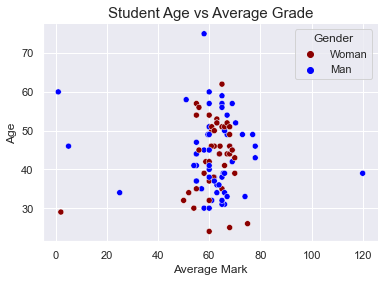

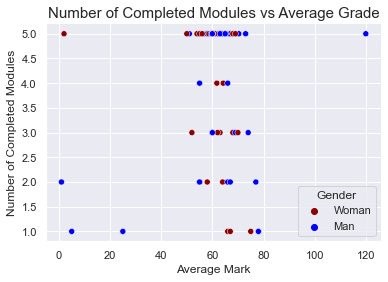

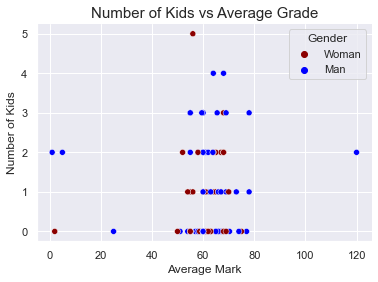

In [17]:
for i in scatter_configs:
    draw_scatter(*i)

**Conclusions:** the grade of 120 is likely to be en error, because the max grade is 100. The grades below 50 shall be examined closer. The grades below 20 should be invetigated since this is a strong failing grade. 

**Dropping the errors**

In [18]:
outlier_indexes_grade = []
for i in range(len(file)):
    if (file["Average_grade"][i] > 100) or (file["Average_grade"][i] <= 5):
        print(i, " ", file["Average_grade"][i])
        outlier_indexes_grade.append(i)

56   2.0
79   120.0
88   1.0
95   5.0


In [19]:
file = file.drop(outlier_indexes_grade)
file = file.reset_index(drop=True)

Visualing the data after cleaning the errors

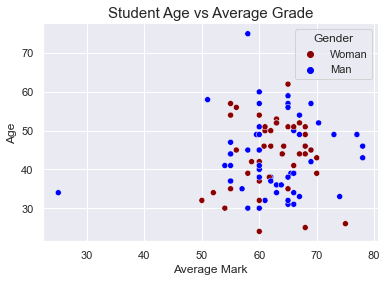

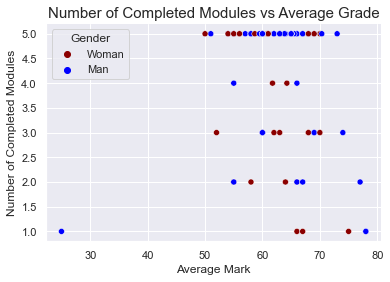

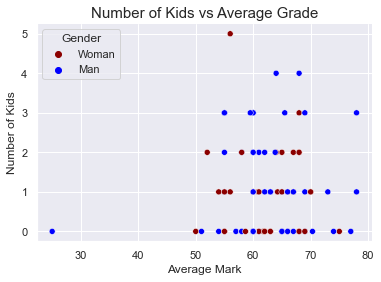

In [20]:
for i in scatter_configs:
    draw_scatter(*i)

**Conclusions:** Age and Average Grade columns show a slight positive correlation for Males in the visualizations, therefore, the correlations are calculated below 

**Calculating correlations**

In [21]:
man = file[file["Gender"] == "Man"]
age_grade_correlation_males = man["Age_by_birth_year"].corr(man["Average_grade"])
age_grade_correlation_males

0.08441444947624857

In [22]:
age_grade_correlation = file["Age_by_birth_year"].corr(file["Average_grade"])
age_grade_correlation

0.06586744545992645

**Calculating all possible correlations in the data above the strength of 0.5**

In [23]:
file.corr()[["Kids", "Average_grade", "Age_by_birth_year", "Modules_num"]][
    (file.corr()[["Kids", "Average_grade", "Age_by_birth_year", "Modules_num"]] >= 0.05)
    | (
        file.corr()[["Kids", "Average_grade", "Age_by_birth_year", "Modules_num"]]
        <= -0.05
    )
]

,Kids,Average_grade,Age_by_birth_year,Modules_num
Kids,1.000000,NaN,0.081854,NaN
Birth_year,-0.081854,-0.065867,-1.000000,-0.128769
Modules_num,NaN,-0.156785,0.128769,1.000000
Average_grade,NaN,1.000000,0.065867,-0.156785
Prediction_grade,-0.050096,0.061169,NaN,-0.231460
Height_cm,NaN,0.087863,NaN,NaN
Age_by_birth_year,0.081854,0.065867,1.000000,0.128769


**Replacing categorical data with number encodings in order to calculate correlations**

In [125]:
file["Gender"].value_counts()

Man      60
Woman    42
Name: Gender, dtype: int64

In [126]:
file["Gender"] = file["Gender"].astype("category")
file["Gender"] = file["Gender"].cat.rename_categories({"Man": 0, "Woman": 1})
file["Gender"].value_counts()

0    60
1    42
Name: Gender, dtype: int64

In [127]:
file["Gender"].corr(file["Average_grade"])

-0.0059261538632224085

In [128]:
file["Excited_data"].value_counts()

Agree                  45
Completely Agree       35
Meh                    19
Disagree                2
Completely Disagree     1
Name: Excited_data, dtype: int64

In [129]:
file["Excited_data"] = file["Excited_data"].astype("category")
file["Excited_data"] = file["Excited_data"].cat.rename_categories(
    {
        "Completely Disagree": 0,
        "Disagree": 1,
        "Meh": 2,
        "Agree": 3,
        "Completely Agree": 4,
    }
)
file["Excited_data"].value_counts()

3    45
4    35
2    19
1     2
0     1
Name: Excited_data, dtype: int64

In [130]:
file["Enjoy_data"].value_counts()

Agree               54
Completely Agree    36
Meh                 10
Disagree             2
Name: Enjoy_data, dtype: int64

In [131]:
file["Enjoy_data"] = file["Enjoy_data"].astype("category")
file["Enjoy_data"] = file["Enjoy_data"].cat.rename_categories(
    {
        "Disagree": 0,
        "Meh": 1,
        "Agree": 2,
        "Completely Agree": 3,
    }
)
file["Enjoy_data"].value_counts()

2    54
3    36
1    10
0     2
Name: Enjoy_data, dtype: int64

In [132]:
file["Gender"].corr(file["Enjoy_data"])

-0.25968501252957216

In [133]:
file["Gender"].corr(file["Excited_data"])

-0.18502714122745145

**Visualing correlations in categorical data**

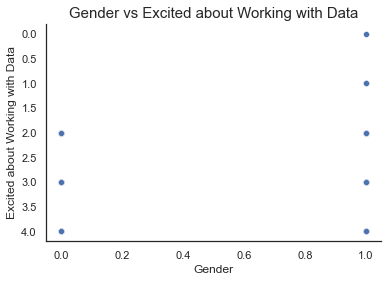

In [134]:
sns.scatterplot(
    data=file,
    x=file["Gender"],
    y=file["Excited_data"],
)
sns.despine()
plt.xlabel("Gender")
plt.ylabel("Excited about Working with Data")
plt.title("Gender vs Excited about Working with Data", fontsize=15)
plt.show()

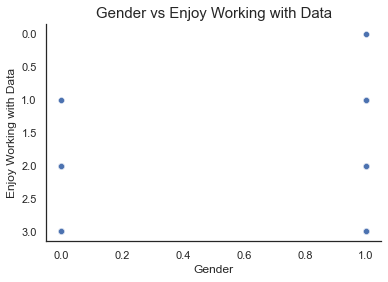

In [135]:
sns.scatterplot(
    data=file,
    x=file["Gender"],
    y=file["Enjoy_data"],
)
sns.despine()
plt.xlabel("Gender")
plt.ylabel("Enjoy Working with Data")
plt.title("Gender vs Enjoy Working with Data", fontsize=15)
plt.show()

**Renaming the categories back not to interrupt other algorithms**

In [136]:
file["Gender"] = file["Gender"].cat.rename_categories(["Man", "Woman"])
file["Enjoy_data"] = file["Enjoy_data"].cat.rename_categories(
    {0: "Disagree", 1: "Meh", 2: "Agree", 3: "Completely Agree"}
)
file["Excited_data"] = file["Excited_data"].cat.rename_categories(
    {
        0: "Completely Disagree",
        1: "Disagree",
        2: "Meh",
        3: "Agree",
        4: "Completely Agree",
    }
)

In [137]:
scatter_configs_cor = [
    [
        "Kids",
        "Age_by_birth_year",
        "Number of Kids",
        "Age",
        "Student Age vs Number of Kids",
    ],
    [
        "Modules_num",
        "Age_by_birth_year",
        "Number of Modules",
        "Age",
        "Student Age vs Number of Modules",
    ],
    [
        "Modules_num",
        "Prediction_grade",
        "Number of Modules",
        "Prediction Grade",
        "Number of Modules vs Prediction Grade",
    ],
]

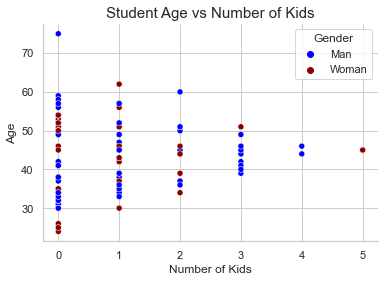

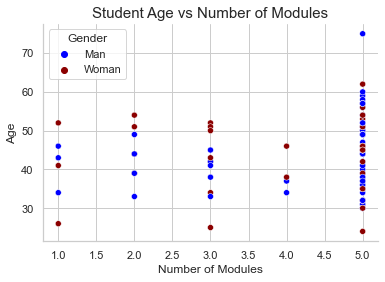

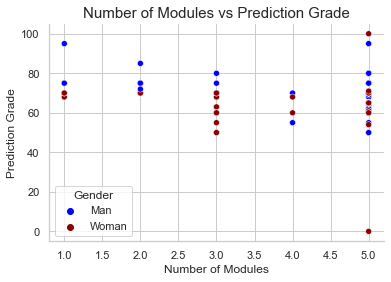

In [142]:
sns.set_style("whitegrid")
for i in scatter_configs_cor:
    draw_scatter(*i)

**Visualing Average Grade in combination with other columns to find relations**

Text(0.5, 1.0, 'Grade vs Number of Kids by Gender')

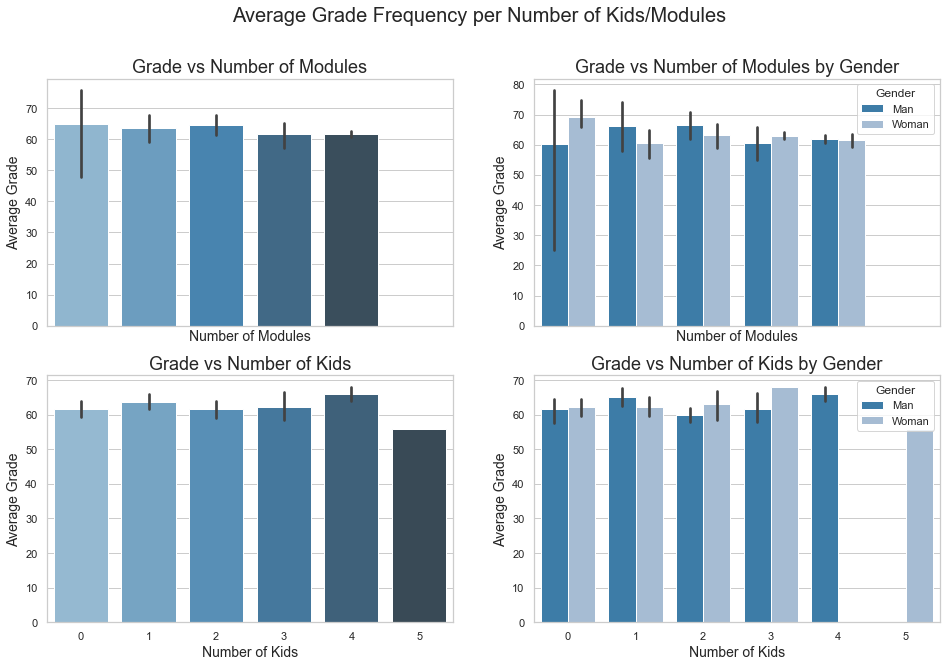

In [143]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16, 10))
fig.suptitle("Average Grade Frequency per Number of Kids/Modules", size=20)

sns.barplot(
    ax=axes[0,0], x="Modules_num", y="Average_grade", data=file, palette="Blues_d"
)
axes[0,0].set_xlabel("Number of Modules", size=14)
axes[0,0].set_ylabel("Average Grade", size=14)
axes[0,0].set_title("Grade vs Number of Modules", size=18)


sns.barplot(
    ax = axes[0,1],
    x="Modules_num",
    y="Average_grade",
    hue="Gender",
    data=file,
    palette=dict({"Woman": "#9ebcda", "Man": "#2c7fb8"}),
)
axes[0,1].set_xlabel("Number of Modules",size=14)
axes[0,1].set_ylabel("Average Grade", size=14)
axes[0,1].set_title("Grade vs Number of Modules by Gender", size=18)


sns.barplot(
    ax=axes[1,0], x="Kids", y="Average_grade", data=file, palette="Blues_d"
)
axes[1,0].set_xlabel("Number of Kids", size=14)
axes[1,0].set_ylabel("Average Grade", size=14)
axes[1,0].set_title("Grade vs Number of Kids", size=18)

sns.barplot(
    ax = axes[1,1],
    x="Kids",
    y="Average_grade",
    hue="Gender",
    data=file,
    palette=dict({"Woman": "#9ebcda", "Man": "#2c7fb8"}),
)
axes[1,1].set_xlabel("Number of Kids", size=14)
axes[1,1].set_ylabel("Average Grade", size=14)
axes[1,1].set_title("Grade vs Number of Kids by Gender", size=18)


**Visualizing Frequency Distributions at RKC**

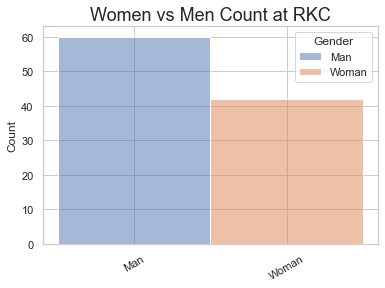

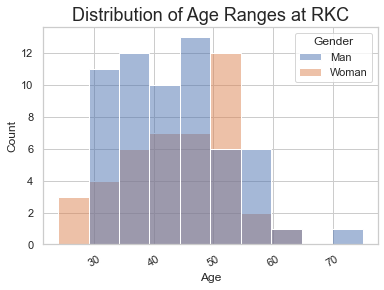

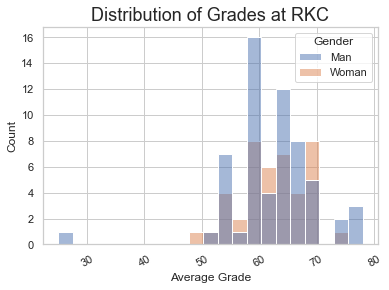

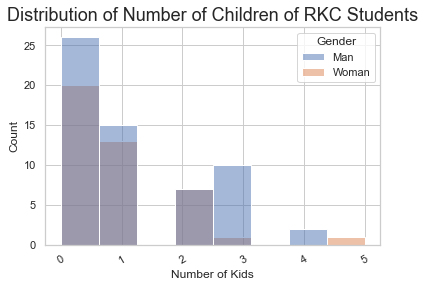

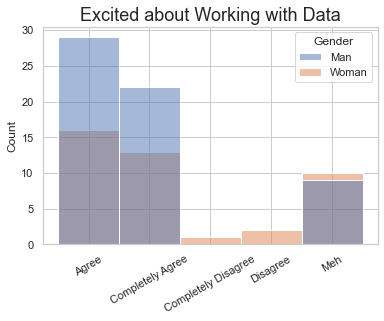

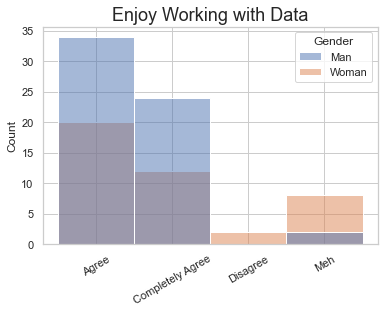

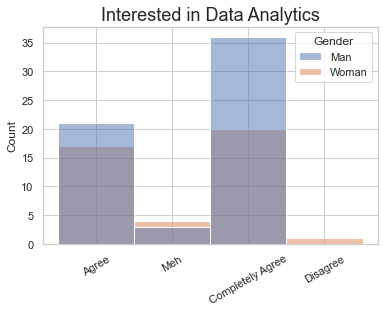

In [144]:
def draw_hist(x, x_label, title):
    sns.histplot(x=x, hue="Gender", data=file)
    plt.title(title, size=18)
    plt.xticks(rotation=30)
    plt.xlabel(x_label)
    plt.show()


hist_configs = [
    ["Gender", "", "Women vs Men Count at RKC"],
    ["Age_by_birth_year", "Age", "Distribution of Age Ranges at RKC"],
    ["Average_grade", "Average Grade", "Distribution of Grades at RKC"],
    ["Kids", "Number of Kids", "Distribution of Number of Children of RKC Students"],
    ["Excited_data", "", "Excited about Working with Data"],
    ["Enjoy_data", "", "Enjoy Working with Data"],
    ["Interested_DA", "", "Interested in Data Analytics"],
]

for i in hist_configs:
    draw_hist(*i)

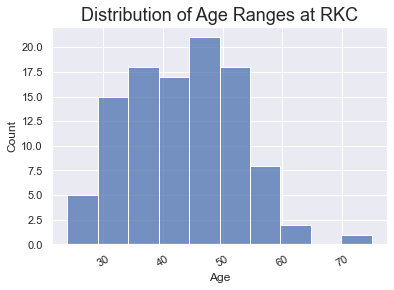

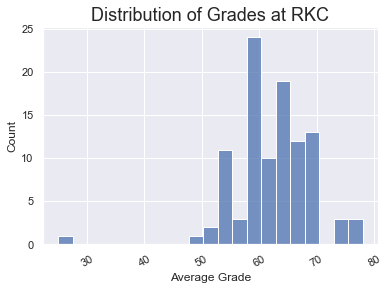

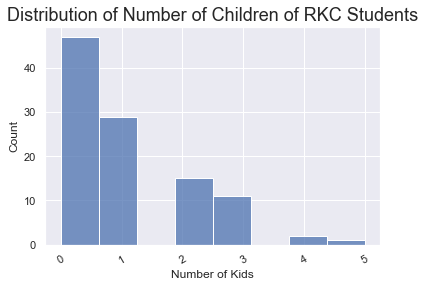

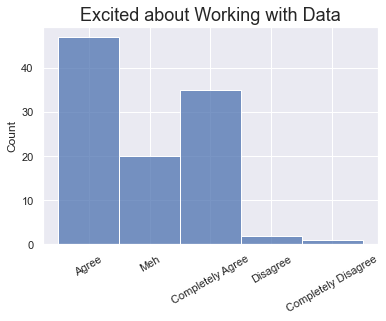

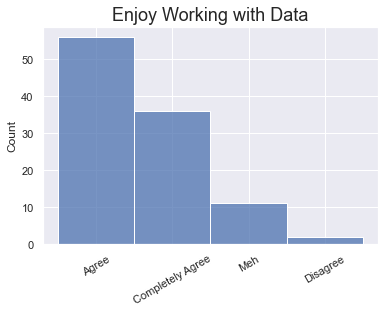

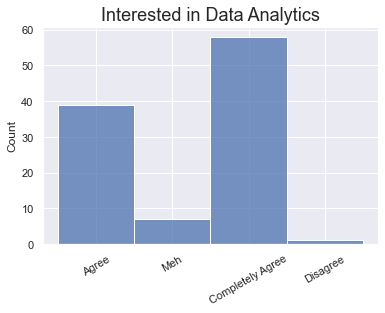

<IPython.core.display.Javascript object>

In [184]:
def draw_hist(x, x_label, title):
    sns.histplot(x=x, data=file)
    plt.title(title, size=18)
    plt.xticks(rotation=30)
    plt.xlabel(x_label)
    plt.show()


hist_configs = [
    ["Age_by_birth_year", "Age", "Distribution of Age Ranges at RKC"],
    ["Average_grade", "Average Grade", "Distribution of Grades at RKC"],
    ["Kids", "Number of Kids", "Distribution of Number of Children of RKC Students"],
    ["Excited_data", "", "Excited about Working with Data"],
    ["Enjoy_data", "", "Enjoy Working with Data"],
    ["Interested_DA", "", "Interested in Data Analytics"],
]

for i in hist_configs:
    draw_hist(*i)

## 6. Statistical Summaries <a class="anchor" id="6"></a>

In [51]:
file.describe()[["Average_grade", "Prediction_grade", "Age_by_birth_year"]]

,Average_grade,Prediction_grade,Age_by_birth_year
count,102.000000,102.000000,102.000000
mean,62.369118,66.529412,43.745098
std,6.799818,10.990280,9.106288
min,25.000000,0.000000,24.000000
25%,60.000000,60.000000,37.000000
50%,62.000000,66.500000,44.000000
75%,66.000000,70.000000,50.000000
max,78.000000,100.000000,75.000000


In [41]:
file["Enjoy_data"].describe()

count       102
unique        4
top       Agree
freq         54
Name: Enjoy_data, dtype: object

In [42]:
file["Excited_data"].describe()

count       102
unique        5
top       Agree
freq         45
Name: Excited_data, dtype: object

In [43]:
file["Afraid_data"].describe()

count          102
unique           5
top       Disagree
freq            39
Name: Afraid_data, dtype: object

In [44]:
file["Interested_DA"].describe()

count                  102
unique                   4
top       Completely Agree
freq                    56
Name: Interested_DA, dtype: object

In [45]:
file["Work_hard"].describe()

count                  102
unique                   4
top       Completely Agree
freq                    60
Name: Work_hard, dtype: object

In [46]:
file["Gender"].describe()

count     102
unique      2
top       Man
freq       60
Name: Gender, dtype: object

In [48]:
file["Height_relative"].describe()

count         102
unique          4
top       average
freq           51
Name: Height_relative, dtype: object

#### Pivot Tables
##### Average Grade Stats by Gender

In [145]:
grouped_by_gender = file.groupby("Gender")
values = grouped_by_gender[["Average_grade"]]
gender_stats = values.agg([np.min, np.max, np.mean, np.std, np.median])
gender_stats.columns = ["Min", "Max", "Mean", "Standard Deviation", "Median"]
gender_stats.iloc[0] = [round(x, 1)for x in gender_stats.iloc[0]]
gender_stats.iloc[1] = [round(x, 1)for x in gender_stats.iloc[1]]

In [146]:
color1 = "white"
color2 = "lightgrey"
header_color = "lightblue"
values = gender_stats.columns, gender_stats.iloc[0], gender_stats.iloc[1]
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["", "Males", "Females"],
                fill_color=header_color,
                height=50,
                align="left",
                font=dict(family="Lato", size=18),
            ),
            cells=dict(
                values=values,
                align="left",
                height=50,
                font=dict(family="Lato", size=20),
                format=None,
                formatsrc=None,
                fill_color=None,
            ),
        )
    ]
)
fig.update_layout(width=610, title="Average Grade Statistical Summaries")
fig.update_layout({"margin": {"t": 50}})
fig.show()

##### Effect of Number of Kids on Average Grade

In [147]:
from scipy import stats

# create a method that groups by and counts agg stats
grouped_by_kids = file.groupby("Kids")
values = grouped_by_kids[["Average_grade"]]
kids_stats = values.agg([np.min, np.max, np.mean, np.std, np.median])
kids_stats.columns = ["Min", "Max", "Mean", "Standard Deviation", "Median"]
kids_stats.iloc[0] = [round(x, 1) for x in kids_stats.iloc[0]]
kids_stats.iloc[1] = [round(x, 1) for x in kids_stats.iloc[1]]
kids_stats.iloc[2] = [round(x, 1) for x in kids_stats.iloc[2]]
kids_stats.iloc[3] = [round(x, 1) for x in kids_stats.iloc[3]]
kids_stats.iloc[4] = [round(x, 1) for x in kids_stats.iloc[4]]
kids_stats.iloc[5] = [round(x, 1) for x in kids_stats.iloc[5]]
kids_stats

,Min,Max,Mean,Standard Deviation,Median
Kids,,,,,
0,25.0,77.0,61.8,8.0,61.9
1,54.0,78.0,63.8,5.5,63.6
2,52.0,68.0,61.6,4.8,61.5
3,55.0,78.0,62.3,7.2,60.0
4,64.0,68.0,66.0,2.8,66.0
5,56.0,56.0,56.0,NaN,56.0


In [148]:
color1 = "white"
color2 = "lightgrey"
header_color = "lightblue"
values = (
    kids_stats.columns,
    kids_stats.iloc[0],
    kids_stats.iloc[1],
    kids_stats.iloc[2],
    kids_stats.iloc[3],
    kids_stats.iloc[4],
    kids_stats.iloc[5],
)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=[
                    "Number of Kids",
                    "No Kids",
                    "1 Kid",
                    "2 Kids",
                    "3 Kids",
                    "4 Kids",
                    "5 Kids",
                ],
                fill_color=header_color,
                height=50,
                align="left",
                font=dict(family="Lato", size=18),
            ),
            cells=dict(
                values=values,
                align="left",
                height=50,
                font=dict(family="Lato", size=20),
                format=None,
                formatsrc=None,
                fill_color=None,
            ),
        )
    ]
)
fig.update_layout(
    width=800, title="Average Grade Statistical Summaries by Number of Kids"
)
fig.update_layout({"margin": {"t": 50}})
fig.show()

In [149]:
grouped_by_excited = file.groupby("Excited_data")
values = grouped_by_excited[["Average_grade"]]
excited_stats = values.agg([np.min, np.max, np.mean, np.std, np.median])
excited_stats.columns = ["Min", "Max", "Mean", "Standard Deviation", "Median"]
excited_stats.iloc[0] = [round(x, 1) for x in excited_stats.iloc[0]]
excited_stats.iloc[1] = [round(x, 1) for x in excited_stats.iloc[1]]
excited_stats.iloc[2] = [round(x, 1) for x in excited_stats.iloc[2]]
excited_stats.iloc[3] = [round(x, 1) for x in excited_stats.iloc[3]]
excited_stats.iloc[4] = [round(x, 1) for x in excited_stats.iloc[4]]
excited_stats

,Min,Max,Mean,Standard Deviation,Median
Excited_data,,,,,
Agree,50.0,70.0,61.2,5.0,60.8
Completely Agree,25.0,78.0,64.0,9.3,65.0
Completely Disagree,66.0,66.0,66.0,NaN,66.0
Disagree,60.0,68.0,64.0,5.7,64.0
Meh,52.0,70.3,61.9,5.0,63.0


In [150]:
color1 = "white"
color2 = "lightgrey"
header_color = "lightblue"
values = (
    excited_stats.columns,
    excited_stats.iloc[0],
    excited_stats.iloc[1],
    excited_stats.iloc[2],
    excited_stats.iloc[3],
    excited_stats.iloc[4],
)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=[
                    "Level of Excitement",
                    "Agree",
                    "Completely Agree",
                    "Completely Disagree",
                    "Disagree",
                    "Meh",
                ],
                fill_color=header_color,
                height=50,
                align="left",
                font=dict(family="Lato", size=18),
            ),
            cells=dict(
                values=values,
                align="left",
                height=50,
                font=dict(family="Lato", size=20),
                format=None,
                formatsrc=None,
                fill_color=None,
            ),
        )
    ]
)
fig.update_layout(
    width=800,
    title="Average Grade Statistical Summaries by Level of Excitement in Working with Data",
)
fig.update_layout({"margin": {"t": 50}})
fig.show()

In [151]:
grouped_by_interested = file.groupby("Interested_DA")
values = grouped_by_interested[["Average_grade"]]
interested_stats = values.agg([np.min, np.max, np.mean, np.std, np.median])
interested_stats.columns = ["Min", "Max", "Mean", "Standard Deviation", "Median"]
interested_stats.iloc[0] = [round(x, 1) for x in interested_stats.iloc[0]]
interested_stats.iloc[1] = [round(x, 1) for x in interested_stats.iloc[1]]
interested_stats.iloc[2] = [round(x, 1) for x in interested_stats.iloc[2]]
interested_stats.iloc[3] = [round(x, 1) for x in interested_stats.iloc[3]]
interested_stats

,Min,Max,Mean,Standard Deviation,Median
Interested_DA,,,,,
Agree,50.0,70.3,61.5,4.9,60.9
Completely Agree,25.0,78.0,63.2,7.9,63.4
Disagree,66.0,66.0,66.0,NaN,66.0
Meh,51.0,68.0,60.3,6.2,61.0


In [152]:
color1 = "white"
color2 = "lightgrey"
header_color = "lightblue"
values = (
    interested_stats.columns,
    interested_stats.iloc[0],
    interested_stats.iloc[1],
    interested_stats.iloc[2],
    interested_stats.iloc[3],
)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=[
                    "Level of Interest",
                    "Agree",
                    "Completely Agree",
                    "Disagree",
                    "Meh",
                ],
                fill_color=header_color,
                height=50,
                align="left",
                font=dict(family="Lato", size=18),
            ),
            cells=dict(
                values=values,
                align="left",
                height=50,
                font=dict(family="Lato", size=20),
                format=None,
                formatsrc=None,
                fill_color=None,
            ),
        )
    ]
)
fig.update_layout(
    width=800,
    title="Average Grade Statistical Summaries by Level of Interest in Working with Data",
)
fig.update_layout({"margin": {"t": 50}})
fig.show()

## 7. Data Visualization for Presentation (Explanatory Visuals) <a class="anchor" id="7"></a>

**Presentation of patterns found in the Exploratory Analysis**

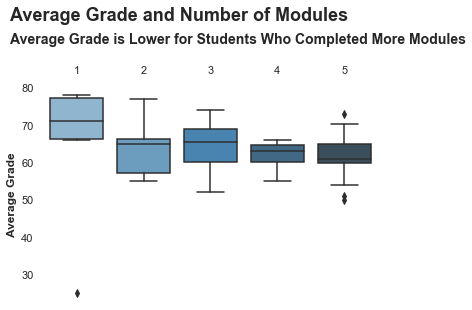

In [153]:
sns.set_style("white")
fig, ax = plt.subplots()
sns.boxplot(
    ax=ax,
    data=file,
    y="Average_grade",
    x="Modules_num",
    palette="Blues_d",
)
ax.tick_params(bottom=False, left=False)
plt.ylabel("Average Grade", size=12, weight="bold")
plt.xlabel("")
ax.text(
    x=-1,
    y=98,
    s="Average Grade and Number of Modules",
    size=18,
    weight="bold",
)
ax.text(
    x=-1,
    y=92,
    s="Average Grade is Lower for Students Who Completed More Modules",
    size=14,
    weight="bold",
)
ax.xaxis.tick_top()
ax.tick_params(top=False, left=False)
sns.despine(left=True, bottom=True)
plt.show()

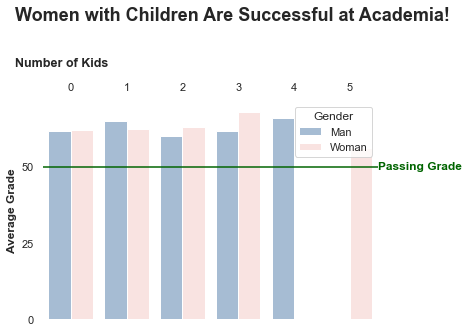

In [154]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, data=file, 
            y="Average_grade", 
            x="Kids", 
            hue="Gender",
            errwidth=0,
            palette=dict({"Woman": "#fde0dd", "Man": "#9ebcda"}))
ax.tick_params(bottom=False, left=False)
plt.ylabel("Average Grade", size=12, weight="bold")
ax.set_xlabel("")
ax.xaxis.set_label_position("top")
ax.text(
    x=-1,
    y=98,
    s="Women with Children Are Successful at Academia!",
    size=18,
    weight="bold",
)
ax.text(
    x=-1,
    y=92,
    s="",
    size=14,
    weight="bold",
)
ax.text(
    x=5.5,
    y=49,
    s="Passing Grade",
    size=12,
    weight="bold",
    c="darkgreen"
)
ax.text(
    x=-1,
    y=83,
    s="Number of Kids",
    size=12.5,
    weight="bold",
    
)
ax.xaxis.tick_top()
plt.yticks([0, 25, 50])
plt.axhline(y = 50, color = 'darkgreen', linestyle = '-')
ax.tick_params(top=False, left=False)
sns.despine(left=True, bottom=True)
plt.show()

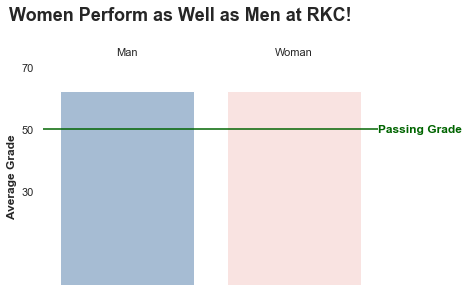

In [155]:
fig, ax = plt.subplots()
sns.barplot(
    ax=ax,
    data=file,
    y="Average_grade",
    x="Gender",
    errwidth=0,
    palette=dict({"Woman": "#fde0dd", "Man": "#9ebcda"})
)
ax.tick_params(bottom=False, left=False)
plt.ylabel("Average Grade", size=12, weight="bold")
plt.xlabel("")
plt.axhline(y = 50, color = 'darkgreen', linestyle = '-')
plt.xticks(size=15)
ax.text(
    x=-0.7,
    y=85,
    s="Women Perform as Well as Men at RKC!",
    size=18,
    weight="bold",
)
ax.text(
    x=-1,
    y=92,
    s="",
    size=14,
    weight="bold",
)
ax.text(
    x=1.5,
    y=49,
    s="Passing Grade",
    size=12,
    weight="bold",
    c="darkgreen"
)
plt.yticks([30,50, 70])
ax.xaxis.tick_top()
ax.tick_params(top=False, left=False)
sns.despine(left=True, bottom=True)
plt.show()

**Visualing Gender Counts for Presentation**

In [37]:
file.shape[0]

102

In [156]:
gender_counts = file["Gender"].value_counts()

fig = go.Figure()
fig.add_trace(
    go.Indicator(
        number={"suffix": "%"},
        value=(gender_counts[0] / file.shape[0]) * 100,
        title="Men",
        gauge={"axis": {"visible": False}},
        domain={"row": 0, "column": 0},
    )
)
fig.add_trace(
    go.Indicator(
        number={"suffix": "%"},
        value=(gender_counts[1] / file.shape[0]) * 100,
        title="Women",
        gauge={"axis": {"visible": False}},
        domain={"row": 0, "column": 1},
    )
)
fig.update_layout(
    grid={"rows": 1, "columns": 2, "pattern": "independent"},
    template={"data": {"indicator": [{"delta": {"reference": 90}}]}},
)

#### Displaying the head for Presentation Slides

In [157]:
display_file = file[
    [
        "Gender",
        "Age_by_birth_year",
        "Kids",
        "Average_grade",
        "Excited_data",
        "Enjoy_data",
    ]
].tail()
display_file.columns = [
    "Gender",
    "Age",
    "Number of Kids",
    "Average Grade",
    "Excited about Data",
    "Enjoy Working with Data",
]
display_file.columns.tolist()

['Gender',
 'Age',
 'Number of Kids',
 'Average Grade',
 'Excited about Data',
 'Enjoy Working with Data']

In [158]:
color1 = "white"
color2 = "lightgrey"
header_color = "lightblue"
values = (
    display_file.iloc[:, 0],
    display_file.iloc[:, 1],
    display_file.iloc[:, 2],
    display_file.iloc[:, 3],
    display_file.iloc[:, 4],
    display_file.iloc[:, 5],
)
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=display_file.columns.tolist(),
                fill_color=header_color,
                height=50,
                align="left",
                font=dict(family="Lato", size=20),
            ),
            cells=dict(
                values=values,
                align="left",
                height=50,
                font=dict(family="Lato", size=20),
                format=None,
                formatsrc=None,
                fill_color=None,
            ),
        )
    ]
)
fig.update_layout(width=1100, height=1000, title="Data Preview")
fig.update_layout({"margin": {"t": 50}})
fig.show()

## 8. Hypothesis Testing <a class="anchor" id="8"></a>

### 8.1 Permutation Tests <a class="anchor" id="8.1"></a>

- **Null Hypothesis: Elder females with kids and younger males with no kids perform equally good at academia**
- **Hypothesis: Elder females with kids perform academically better than younger males with no kids**

There is a probability that the difference between the means of groups is random and, permutation tests are used to calculate this probability that is further referred to as the p-value. It is a best practice to use the p-value of 5% as a threshold, where if the p-value in randomized tests is less than 5%, the difference is considered nonrandom, thus, the null hypothesis is rejected and the alternative hypothesis is accepted, otherwise, the difference is considered random, thus, the null hypothesis can not be rejected and the alternative hypothesis is rejected.

1. we aggregate the data and find the mean per each group
2. calculate the mean difference

In [159]:
elder_female_with_kids = file[
    (file["Age_by_birth_year"] > 40) & (file["Kids"] > 0) & (file["Gender"] == "Woman")
]
elder_female_with_kids_average_grade = elder_female_with_kids["Average_grade"].mean()

younger_male_no_kids = file[
    (file["Kids"] == 0) & (file["Age_by_birth_year"] <= 40) & (file["Gender"] == "Man")
]
younger_male_no_kids_average_grade = younger_male_no_kids["Average_grade"].mean()

mean_difference = (
    elder_female_with_kids_average_grade - younger_male_no_kids_average_grade
)
mean_difference

3.8237104072398154

3. we get the list of all grade values
4. randomly assign these values either to male or to female group
5. conduct the random assignment repeteadly 1000 times (simulating a new study)
6. calculate the mean differences on each iteration and append to a separate list
6. create a dictionary of frequencies of each possible mean difference value

In [160]:
iter_mean_differences = []
group_a_values = elder_female_with_kids["Average_grade"].tolist()
group_b_values = younger_male_no_kids["Average_grade"].tolist()
all_grades = group_a_values + group_b_values

for i in range(1000):
    males = []
    females = []
    for grade in all_grades:
        random_value = np.random.rand()
        if random_value >= 0.5:
            males.append(grade)
        else:
            females.append(grade)
    iteration_mean_difference = np.mean(females) - np.mean(males)
    iter_mean_differences.append(iteration_mean_difference)

sampling_distribution = {}

for iter_mean_difference in iter_mean_differences:
    if sampling_distribution.get(iter_mean_difference, False):
        val = sampling_distribution.get(iter_mean_difference)
        val = val + 1
        sampling_distribution[iter_mean_difference] = val
    else:
        sampling_distribution[iter_mean_difference] = 1

8. determine if the mean difference was random or not
- we set a p value threshold of 0.05 (5%)
- we find the frequency of a mean diffirence equal or higher than the mean dif observed in our dataset
- we divide the amount of such mean diffirences by the number of simulated random datasets

In [161]:
frequencies = []
for key in sampling_distribution.keys():
    if key >= mean_difference:
        frequencies.append(key)
frequencies
sum_freq = len(frequencies)
p_value = sum_freq / 1000
p_value

0.113

In [162]:
fig = go.Figure()
fig.add_trace(
    go.Indicator(
        value=p_value * 100,
        number={"suffix": "%"},
        title="Calculated P-Value",
        gauge={"axis": {"visible": False}},
        domain={"row": 0, "column": 0},
    )
)
fig.add_trace(
    go.Indicator(
        number={"suffix": "%"},
        value=0.05 * 100,
        title="Threshold",
        gauge={"axis": {"visible": False}},
        domain={"row": 0, "column": 1},
    )
)
fig.update_layout(
    grid={"rows": 1, "columns": 2, "pattern": "independent"},
    template={"data": {"indicator": [{"delta": {"reference": 90}}]}},
)

#### **Conclusion:**
The p value is 0.117, which is higher than the threshold of 0.05, therefore, the null hypothesis can not be rejected and the alternative hypothesis is rejected. In conclusion, women over 40 with kids do not academically outperform younger men with no kids, and the initially calculated difference was due to a random chance.

### 8.2 Student's T-Tests <a class="anchor" id="8.2"></a>

To conduct a t-test the t-value should be calculated and compared to the critical value. If the t-value is more than the critical value, then the null hypothesis is rejected and the alternative hypothesis is accepted. Otherwise, it is considered that there is no significant difference between the groups. The t-value is found by diving the signal by the noise, where the signal is the difference between the averages of the groups, and the noise is the square root of sums of variances divided by the number of samples in the group. The critical value is found using the degree of freedom and the p-value that is the probability of the difference occurring by chance.

In [163]:
## testing the same null and alternative hypotheses
elder_female_with_kids = file[
    (file["Age_by_birth_year"] > 40) & (file["Kids"] > 0) & (file["Gender"] == "Woman")
]
elder_female_with_kids_average_grade = elder_female_with_kids["Average_grade"].mean()

younger_male_no_kids = file[
    (file["Kids"] == 0) & (file["Age_by_birth_year"] <= 40) & (file["Gender"] == "Man")
]
younger_male_no_kids_average_grade = younger_male_no_kids["Average_grade"].mean()

mean_difference = (
    elder_female_with_kids_average_grade - younger_male_no_kids_average_grade
)
print(
    "Elder women with kids: ",
    elder_female_with_kids_average_grade,
    "\nYounger men no kids: ",
    younger_male_no_kids_average_grade,
    "\nDifference: ",
    mean_difference,
)

Elder women with kids:  63.59294117647058 
Younger men no kids:  59.76923076923077 
Difference:  3.8237104072398154


In [164]:
fig = go.Figure()

fig.add_trace(
    go.Indicator(
        value=round(elder_female_with_kids_average_grade, 1),
        title="Average Grade of Elder Females with Kids",
        gauge={"axis": {"visible": False}},
        domain={"row": 0, "column": 0},
    )
)
fig.add_trace(
    go.Indicator(
        value=round(younger_male_no_kids_average_grade, 1),
        title="Average Grade of Younger Males with No Kids",
        gauge={"axis": {"visible": False}},
        domain={"row": 1, "column": 0},
    )
)

fig.update_layout(
    grid={"rows": 2, "columns": 1, "pattern": "independent"},
    template={"data": {"indicator": [{"delta": {"reference": 90}}]}},
)

#### 1. finding the signal - difference between the mean

In [165]:
signal = mean_difference
signal

3.8237104072398154

#### 2. finding the group variability

In [166]:
variance_group_a = elder_female_with_kids["Average_grade"].var()
variance_group_b = younger_male_no_kids["Average_grade"].var()

print("Variance of Group A (elder females with kids): ", variance_group_a)
print("Variance of Group B (younger males with no kids): ", variance_group_b)

Variance of Group A (elder females with kids):  21.830909558823528
Variance of Group B (younger males with no kids):  133.85897435897434


In [167]:
num_group_a = elder_female_with_kids["Average_grade"].count()
num_group_b = younger_male_no_kids["Average_grade"].count()

print("Number of samples in Group A (elder females with kids): ", num_group_a)
print("Number of samples in Group B (younger males with no kids): ", num_group_b)

Number of samples in Group A (elder females with kids):  17
Number of samples in Group B (younger males with no kids):  13


#### 3. finding the t-value

In [168]:
t_value = signal / math.sqrt(
    (variance_group_a / num_group_a) + (variance_group_b / num_group_b)
)
print("T-value is ", t_value)

T-value is  1.123599855845671


#### 4. finding the degree of freedom

In [169]:
degree_free = num_group_a + num_group_b - 2
degree_free

28

#### 5. finding the critical value

In [170]:
critical_value = scipy.stats.t.ppf(q=1 - 0.05 / 2, df=28)
critical_value

2.048407141795244

#### 6. comparing the t-value and the critical value

In [171]:
result = max(t_value, critical_value)
result

2.048407141795244

In [172]:
fig = go.Figure()

fig.add_trace(
    go.Indicator(
        value=t_value,
        title="T-Value",
        gauge={"axis": {"visible": False}},
        domain={"row": 0, "column": 0},
    )
)
fig.add_trace(
    go.Indicator(
        value=critical_value,
        title="Critical Value",
        gauge={"axis": {"visible": False}},
        domain={"row": 0, "column": 1},
    )
)

fig.update_layout(
    grid={"rows": 1, "columns": 2, "pattern": "independent"},
    template={"data": {"indicator": [{"delta": {"reference": 90}}]}},
)

#### **Conclusion:**
As a result the t-value of 1.12 is less than the critical value of 2.05, therefore, the null hypothesis can not be rejected. However, from this result we can derive a conclusion that elder females with kids perform equally good at academia as younger males with no kids. The conclusion can be used in marketing campaigns to attract more females with kids to RKC.

### 8.3 Comparing Proportions <a class="anchor" id="8.3"></a>
- **Null Hypothesis: Men and females equally enjoy working with data**
- **Hypothesis: Men enjoy working with data more than females**

In [173]:
males = (file["Gender"] == "Man").sum()
females = (file["Gender"] == "Woman").sum()

males_enj_data = (
    (file["Gender"] == "Man")
    & ((file["Enjoy_data"] == "Agree") | (file["Enjoy_data"] == "Completely Agree"))
).sum()
females_enj_data = (
    (file["Gender"] == "Woman")
    & ((file["Enjoy_data"] == "Agree") | (file["Enjoy_data"] == "Completely Agree"))
).sum()

proportion_males_enj = round(males_enj_data / males, 2) * 100
proportion_females_enj = round(females_enj_data / females, 2) * 100
print(
    "Males proportion who enjoy data: ",
    proportion_males_enj,
    " Females proportion: ",
    proportion_females_enj,
)

Males proportion who enjoy data:  97.0  Females proportion:  76.0


In [174]:
males_exc_data = (
    (file["Gender"] == "Man")
    & ((file["Excited_data"] == "Agree") | (file["Excited_data"] == "Completely Agree"))
).sum()
females_exc_data = (
    (file["Gender"] == "Woman")
    & ((file["Excited_data"] == "Agree") | (file["Excited_data"] == "Completely Agree"))
).sum()

proportion_males_exc = round(males_exc_data / males, 2) * 100
proportion_females_exc = round(females_exc_data / females, 2) * 100
print(
    "Males proportion who are excited to work with data: ",
    proportion_males_exc,
    " Females proportion: ",
    proportion_females_exc,
)

Males proportion who are excited to work with data:  85.0  Females proportion:  69.0


#### Displaying the data with Indicators

In [175]:
fig = go.Figure()

fig.add_trace(
    go.Indicator(
        number={"suffix": "%"},
        value=proportion_males_enj,
        title="Males, enjoy working with data",
        gauge={"axis": {"visible": False}},
        domain={"row": 0, "column": 0},
    )
)
fig.add_trace(
    go.Indicator(
        number={"suffix": "%"},
        value=proportion_females_enj,
        title="Females, enjoy working with data",
        gauge={"axis": {"visible": False}},
        domain={"row": 0, "column": 1},
    )
)
fig.add_trace(
    go.Indicator(
        number={"suffix": "%"},
        value=proportion_males_exc,
        title="Males, excited to work with data",
        gauge={"axis": {"visible": False}},
        domain={"row": 1, "column": 0},
    )
)
fig.add_trace(
    go.Indicator(
        number={"suffix": "%"},
        value=proportion_females_exc,
        title="Females, excited to work with data",
        gauge={"axis": {"visible": False}},
        domain={"row": 1, "column": 1},
    )
)

fig.update_layout(
    grid={"rows": 2, "columns": 2, "pattern": "independent"},
    template={"data": {"indicator": [{"delta": {"reference": 90}}]}},
)